<a id="title"></a>
# Manual Recalibration with calwf3: Turning off the IR Linear Ramp Fit
***

## Learning Goals

This notebook shows two reprocessing examples for WFC3/IR observations impacted by time-variable background (TVB). 

By the end of this tutorial, you will:
- Analyze exposure statistics for each read in an IMA file using `pstat`.
- Reprocess a single exposure and an image association using `calwf3`.
- Combine the reprocessed exposures using `astrodrizzle`.

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Download the data](#download) <br>
[3. Query CRDS for reference files](#query) <br>
[4. Diagnose TVB and reprocess a single exposure](#exec1) <br>
[5. Reprocess multiple exposures in an association](#exec2) <br>
[6. Conclusions](#conclusion) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction

Exposures in the F105W and F110W filters may be impacted by Helium I emission from the Earth's atmosphere at 1.083 microns. This typically affects the reads taken closest in time to Earth occultation. The emission produces a flat background signal which is added to the total background in a subset of reads. In some cases, this non-linear signal may be strong enough to compromise the ramp fitting performed by ``calwf3``, which is designed to flag and remove cosmic rays and saturated reads. The affected calibrated FLT data products will have much larger noise and a non-gaussian sky background. 

This notebook demonstrates how to diagnose and correct for a non-linear background and is based on the 'Last-minus-first' technique described in WFC3 ISR 2016-16: [Reprocessing WFC3/IR Exposures Affected by Time-Variable Backgrounds](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-16.pdf). This turns off the ramp fitting step in ``calwf3`` and treats the IR detector like a CCD that accumulates charge and is read out only at the end of the exposure. In this case, the observed count rate is determined by simply subtracting the first from the last read of the detector and dividing by the time elapsed between the two reads.

While non-linear background also impacts the IR grisms, the method described here should not be used to correct G102 and G141 observations, which are affected by a combination of Helium I, Zodiacal background, and scattered Earth light, each of which varies spatially across the detector. More detail on correcting grism data is provided in WFC3 ISR 2020-04: [The dispersed infrared background in WFC3 G102 and G141 observations](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2020/WFC3_IR_2020-04.pdf).

<a id="imports"></a>
## 1. Imports

This notebook assumes you have installed the required libraries as described [here](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/calwf3_recalibration).

We import:
- *glob* for finding lists of files
- *os* for setting environment variables
- *shutil* for managing directories

- *matplotlib.pyplot* for plotting data
- *astropy.io fits* for accessing FITS files
- *astroquery.mast Observations* for downloading data from MAST
- *ccdproc* for building the association
- *drizzlepac astrodrizzle* for combining images
- *stwcs* for updating the World Coordinate System

- *wfc3tools calwf3 and pstat* for calibrating WFC3 data and plotting statistics of WFC3 data

In [1]:
%matplotlib inline

import glob
import os
import shutil 

import matplotlib.pyplot as plt

from astropy.io import fits
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from drizzlepac import astrodrizzle
from stwcs import updatewcs

from wfc3tools import calwf3, pstat

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


<a id="download"></a>
## 2. Download the data

The following commands query MAST for the necessary products and then downloads them to the current directory. Here we obtain WFC3/IR observations from CANDELS program [12242](http://www.stsci.edu/cgi-bin/get-proposal-info?id=12442&observatory=HST), Visit BF. The data products requested are the ASN, RAW, IMA, FLT, and DRZ files.

#### Warning: this cell may take a few minutes to complete.

In [2]:
data_list = Observations.query_criteria(obs_id='IBOHBF040')

Observations.download_products(
    data_list['obsid'], 
    project='CALWF3', 
    download_dir='./data', 
    mrp_only=False, 
    productSubGroupDescription=['ASN', 'RAW', 'IMA', 'FLT', 'DRZ'])

science_files = glob.glob('data/mastDownload/HST/*/*fits')

for im in science_files:
    root = os.path.basename(im)
    new_path = os.path.join('.', root)
    os.rename(im, new_path)

data_directory = './data'

try:
    if os.path.isdir(data_directory):
        shutil.rmtree(data_directory)
except Exception as e:
    print(f"An error occured while deleting the directory {data_directory}: {e}")

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


The association file for visit BF comprises six consecutive exposures in F105W acquired in a single visit over 3 orbits. Each orbit consists of two 1600 sec exposures, followed by the Earth occultation. Each exposure is dithered by a small fraction of the field of view, where the POSTARG values listed below are in arseconds.

In [3]:
image_collection = ImageFileCollection(
    './',
    keywords=[
        "asn_id",
        "targname",
        "filter",
        "samp_seq",
        "nsamp",
        "exptime",
        "postarg1",
        "postarg2",
        "date-obs",
        "time-obs",
    ], 
    glob_include="*flt.fits",
    ext=0,
)

try:
    summary_table = image_collection.summary
    if summary_table:
        print(summary_table)
    else:
        print("No FITS files matched the pattern or no relevant data found.")
except Exception as e:
    print(f"An error occurred while creating the summary table: {e}")

       file          asn_id    targname   ... postarg2  date-obs  time-obs
------------------ --------- ------------ ... -------- ---------- --------
ibohbfb7q_flt.fits IBOHBF040 GOODN-N1-VBF ...   -0.212 2013-01-06 18:23:01
ibohbfb9q_flt.fits IBOHBF040 GOODN-N1-VBF ...    -0.03 2013-01-06 18:50:42
ibohbfbdq_flt.fits IBOHBF040 GOODN-N1-VBF ...    0.273 2013-01-06 19:18:23
ibohbfbgq_flt.fits IBOHBF040 GOODN-N1-VBF ...    0.091 2013-01-06 19:48:08
ibohbfbkq_flt.fits IBOHBF040 GOODN-N1-VBF ...    0.212 2013-01-06 20:15:49
ibohbfbpq_flt.fits IBOHBF040 GOODN-N1-VBF ...    0.394 2013-01-06 20:43:30


<a id="query"></a>
## 3. Query CRDS for reference files 

Before running `calwf3`, we need to set some environment variables for several subsequent calibration tasks.

We will point to a subdirectory called `crds_cache/` using the IREF environment variable. The IREF variable is used for WFC3 reference files. Other instruments use other variables, e.g., JREF for ACS.

In [4]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'

The code block below will query CRDS for the best reference files currently available for these datasets and update the header keywords to point to these new files. We will use the Python package `os` to run terminal commands. In the terminal, the line would be:

```crds bestrefs --files [filename] --sync-references=1 --update-bestrefs```

...where 'filename' is the name of your fits file.

#### Warning: this cell may take a few minutes to complete.

In [5]:
raw_files = glob.glob('*_raw.fits')

for file in raw_files:
    command_line_input = f'crds bestrefs --files {file} --sync-references=1 --update-bestrefs'
    os.system(command_line_input)

CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap       678 bytes  (1 / 142 files) (0 / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap       977 bytes  (2 / 142 files) (678 / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap         642 bytes  (3 / 142 files) (1.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap       685 bytes  (4 / 142 files) (2.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap         696 bytes  (5 / 142 files) (3.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap    30.0 K bytes  (6 / 142 files) (3.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap       801 bytes  (7 / 142 files) (33.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_darkfile_0250.rmap   178.4 K bytes  (8 / 142 files) (34.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_biasfile_0250.rmap     3.3 K bytes  (9 / 142 files) (212.8 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_atodfile_0250.rmap       874 bytes  (10 / 142 files) (216.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfpc2_0250.imap                782 bytes  (11 / 142 files) (217.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_snkcfile_0003.rmap        681 bytes  (12 / 142 files) (217.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_satufile_0002.rmap      1.0 K bytes  (13 / 142 files) (218.5 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_pfltfile_0253.rmap     34.2 K bytes  (14 / 142 files) (219.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_pctetab_0004.rmap         698 bytes  (15 / 142 files) (253.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_oscntab_0250.rmap         747 bytes  (16 / 142 files) (254.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_npolfile_0254.rmap      4.0 K bytes  (17 / 142 files) (255.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_nlinfile_0250.rmap        726 bytes  (18 / 142 files) (259.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_mdriztab_0254.rmap        845 bytes  (19 / 142 files) (259.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_imphttab_0256.rmap        683 bytes  (20 / 142 files) (260.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_idctab_0254.rmap          661 bytes  (21 / 142 files) (261.4 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_flshfile_0256.rmap      5.8 K bytes  (22 / 142 files) (262.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_drkcfile_0194.rmap    234.8 K bytes  (23 / 142 files) (267.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_dfltfile_0002.rmap     17.1 K bytes  (24 / 142 files) (502.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_darkfile_0492.rmap    276.0 K bytes  (25 / 142 files) (519.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_d2imfile_0251.rmap        605 bytes  (26 / 142 files) (795.8 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_crrejtab_0250.rmap        803 bytes  (27 / 142 files) (796.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_ccdtab_0250.rmap          799 bytes  (28 / 142 files) (797.2 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_bpixtab_0310.rmap      11.7 K bytes  (29 / 142 files) (798.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_biasfile_0267.rmap     23.4 K bytes  (30 / 142 files) (809.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_biacfile_0003.rmap        692 bytes  (31 / 142 files) (833.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_atodtab_0250.rmap         651 bytes  (32 / 142 files) (833.8 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_wfc3_0595.imap               1.3 K bytes  (33 / 142 files) (834.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmttab_0002.rmap       745 bytes  (34 / 142 files) (835.7 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmgtab_0012.rmap       767 bytes  (35 / 142 files) (836.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_tmctab_0052.rmap       743 bytes  (36 / 142 files) (837.2 K / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_thruput_0056.rmap  329.6 K bytes  (37 / 142 files) (837.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_thermal_0003.rmap   20.4 K bytes  (38 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_obsmodes_0004.rmap      743 bytes  (39 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_synphot_0067.imap              579 bytes  (40 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_xtractab_0250.rmap        815 bytes  (41 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_wcptab_0251.rmap          578 bytes  (42 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_teltab_0250.rmap          745 bytes  (43 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_tdstab_0254.rmap          921 bytes  (44 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_tdctab_0252.rmap          650 bytes  (45 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_srwtab_0250.rmap          745 bytes  (46 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_sptrctab_0251.rmap        895 bytes  (47 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_sdctab_0251.rmap          889 bytes  (48 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_riptab_0254.rmap          877 bytes  (49 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_phottab_0258.rmap       1.6 K bytes  (50 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_pfltfile_0250.rmap     23.7 K bytes  (51 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_pctab_0250.rmap         3.1 K bytes  (52 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_mofftab_0250.rmap         747 bytes  (53 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_mlintab_0250.rmap         601 bytes  (54 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_lfltfile_0250.rmap     11.8 K bytes  (55 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_lamptab_0250.rmap         610 bytes  (56 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_inangtab_0250.rmap        815 bytes  (57 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_imphttab_0252.rmap        616 bytes  (58 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_idctab_0251.rmap          775 bytes  (59 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_halotab_0250.rmap         747 bytes  (60 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_gactab_0250.rmap          651 bytes  (61 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_exstab_0250.rmap          745 bytes  (62 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap        749 bytes  (63 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_disptab_0250.rmap         813 bytes  (64 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_darkfile_0353.rmap     59.7 K bytes  (65 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_crrejtab_0250.rmap        711 bytes  (66 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_cdstab_0250.rmap          745 bytes  (67 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_ccdtab_0252.rmap          893 bytes  (68 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_bpixtab_0250.rmap         845 bytes  (69 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_biasfile_0355.rmap    119.5 K bytes  (70 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_apertab_0250.rmap         588 bytes  (71 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_apdestab_0252.rmap        636 bytes  (72 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_stis_0369.imap               1.7 K bytes  (73 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_zprattab_0250.rmap      646 bytes  (74 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_tempfile_0250.rmap    1.1 K bytes  (75 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_tdffile_0250.rmap     8.9 K bytes  (76 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_saadfile_0250.rmap      771 bytes  (77 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_saacntab_0250.rmap      594 bytes  (78 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_rnlcortb_0250.rmap      771 bytes  (79 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pmskfile_0250.rmap      603 bytes  (80 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pmodfile_0250.rmap      603 bytes  (81 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_phottab_0250.rmap       862 bytes  (82 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_pedsbtab_0250.rmap      594 bytes  (83 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_noisfile_0250.rmap    2.6 K bytes  (84 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_nlinfile_0250.rmap    1.7 K bytes  (85 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_maskfile_0250.rmap    1.2 K bytes  (86 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_illmfile_0250.rmap    5.8 K bytes  (87 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_idctab_0250.rmap        767 bytes  (88 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_flatfile_0250.rmap   11.0 K bytes  (89 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_darkfile_0250.rmap   14.9 K bytes  (90 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_nicmos_0250.imap             1.1 K bytes  (91 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_ywlkfile_0003.rmap         922 bytes  (92 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_xwlkfile_0002.rmap         922 bytes  (93 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_xtractab_0269.rmap       1.6 K bytes  (94 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_wcptab_0257.rmap         1.3 K bytes  (95 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_twozxtab_0277.rmap         990 bytes  (96 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_tracetab_0276.rmap         998 bytes  (97 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_tdstab_0271.rmap           803 bytes  (98 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_spwcstab_0255.rmap       1.1 K bytes  (99 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_spottab_0006.rmap          766 bytes  (100 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_proftab_0276.rmap        1.0 K bytes  (101 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_phatab_0250.rmap           668 bytes  (102 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_lamptab_0264.rmap        1.4 K bytes  (103 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_hvtab_0259.rmap            567 bytes  (104 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_hvdstab_0002.rmap        1.0 K bytes  (105 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_gsagtab_0259.rmap          712 bytes  (106 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_geofile_0250.rmap          670 bytes  (107 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_fluxtab_0282.rmap        1.7 K bytes  (108 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_flatfile_0264.rmap       1.8 K bytes  (109 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_disptab_0276.rmap        1.7 K bytes  (110 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_dgeofile_0002.rmap         909 bytes  (111 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_deadtab_0250.rmap          711 bytes  (112 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_brsttab_0250.rmap          696 bytes  (113 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_brftab_0250.rmap           614 bytes  (114 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_bpixtab_0260.rmap          773 bytes  (115 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_badttab_0252.rmap          643 bytes  (116 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_cos_0357.imap                1.4 K bytes  (117 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_spottab_0251.rmap          641 bytes  (118 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_snkcfile_0097.rmap       7.3 K bytes  (119 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_shadfile_0251.rmap         531 bytes  (120 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_satufile_0002.rmap       1.2 K bytes  (121 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_pfltfile_0253.rmap      69.2 K bytes  (122 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_pctetab_0253.rmap          615 bytes  (123 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap          781 bytes  (124 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_npolfile_0253.rmap       3.2 K bytes  (125 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mlintab_0250.rmap          646 bytes  (126 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_mdriztab_0253.rmap         769 bytes  (127 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_imphttab_0260.rmap         769 bytes  (128 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_idctab_0256.rmap         1.5 K bytes  (129 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_flshfile_0268.rmap       3.4 K bytes  (130 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_drkcfile_0448.rmap      14.8 K bytes  (131 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_dgeofile_0250.rmap       3.2 K bytes  (132 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_darkfile_0439.rmap      86.8 K bytes  (133 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_d2imfile_0253.rmap         601 bytes  (134 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_crrejtab_0251.rmap         945 bytes  (135 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_cfltfile_0250.rmap       1.2 K bytes  (136 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_ccdtab_0256.rmap         1.4 K bytes  (137 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_bpixtab_0252.rmap        1.0 K bytes  (138 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_biasfile_0437.rmap      56.9 K bytes  (139 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_atodtab_0251.rmap          528 bytes  (140 / 142 files) (1.8 M / 1.8 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_acs_0538.imap                1.3 K bytes  (141 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/mappings/hst/hst_1177.pmap                      495 bytes  (142 / 142 files) (1.8 M / 1.8 M bytes)
CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfb9q_raw.fits


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/3562021pi_mdz.fits       40.3 K bytes  (1 / 11 files) (0 / 404.6 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/35620245i_drk.fits      302.6 M bytes  (2 / 11 files) (40.3 K / 404.6 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/3562033hi_bpx.fits      838.1 K bytes  (3 / 11 files) (302.6 M / 404.6 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/4ac18263i_dfl.fits       10.5 M bytes  (4 / 11 files) (303.5 M / 404.6 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/4ac19225i_pfl.fits       10.5 M bytes  (5 / 11 files) (314.0 M / 404.6 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/4af1533ai_imp.fits       40.3 K bytes  (6 / 11 files) (324.6 M / 404.6 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/q911321mi_osc.fits       20.2 K bytes  (7 / 11 files) (324.6 M / 404.6 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/t2c16200i_ccd.fits       17.3 K bytes  (8 / 11 files) (324.6 M / 404.6 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/u1k1727mi_lin.fits       79.9 M bytes  (9 / 11 files) (324.6 M / 404.6 M bytes)


CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/u6a1748ri_crr.fits       14.4 K bytes  (10 / 11 files) (404.5 M / 404.6 M bytes)
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/w3m18525i_idc.fits       20.2 K bytes  (11 / 11 files) (404.6 M / 404.6 M bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  155 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfbgq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfbkq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfb7q_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfbdq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfbpq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


<a id="exec1"></a>
## 4. Diagnose TVB and reprocess a single exposure

In this example, we assume that the observer desires to reprocess only a single exposure with the ramp fitting step turned off. This is done by setting the CRCORR switch to OMIT from the default value (PERFORM).

First, we list the contents of the image association 'ibohbf040'. This provides the rootnames of the six dithered exposures. 

In [6]:
fits.getdata('ibohbf040_asn.fits', 1)

FITS_rec([('IBOHBFB7Q', 'EXP-DTH',  1), ('IBOHBFB9Q', 'EXP-DTH',  1),
          ('IBOHBFBDQ', 'EXP-DTH',  1), ('IBOHBFBGQ', 'EXP-DTH',  1),
          ('IBOHBFBKQ', 'EXP-DTH',  1), ('IBOHBFBPQ', 'EXP-DTH',  1),
          ('IBOHBF040', 'PROD-DTH',  1)],
         dtype=(numpy.record, [('MEMNAME', 'S14'), ('MEMTYPE', 'S14'), ('MEMPRSNT', 'i1')]))

Here, we compare the first two images in the set: 'ibohbfb7q' and 'ibohbfb9q'. The first is has a nominal background with a constant rate and the second has a strongly non-linear background.

Text(0.5, 1.0, 'ibohbfb9q (Non-linear Bkg)')

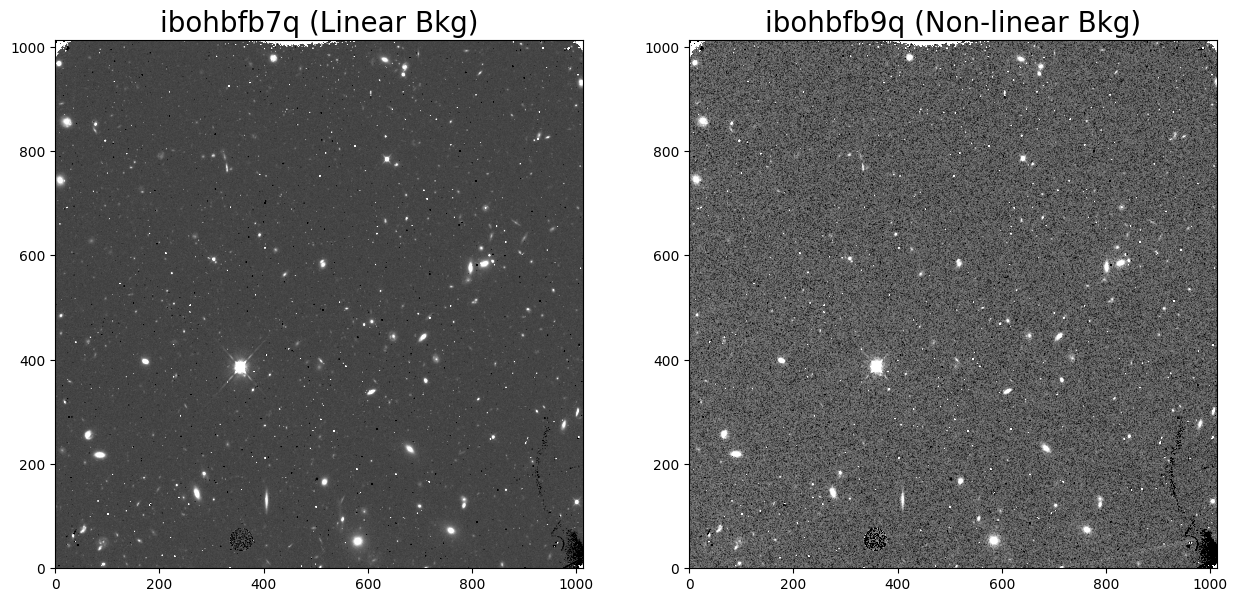

In [7]:
b7q_data = fits.getdata('ibohbfb7q_flt.fits', ext=1)
b9q_data = fits.getdata('ibohbfb9q_flt.fits', ext=1)

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(b7q_data, vmin=0.25, vmax=1.25, cmap='Greys_r', origin='lower')
ax2.imshow(b9q_data, vmin=1.25, vmax=2.25, cmap='Greys_r', origin='lower')

ax1.set_title('ibohbfb7q (Linear Bkg)', fontsize=20)
ax2.set_title('ibohbfb9q (Non-linear Bkg)', fontsize=20)

Next, we compare histograms of the two FLT frames.  Exposure 'ibohbfb9q' has a strongly non-gaussian background with three separate peaks due to a poor ramp fit during `calwf3` processing.

Text(0, 0.5, 'Frequency')

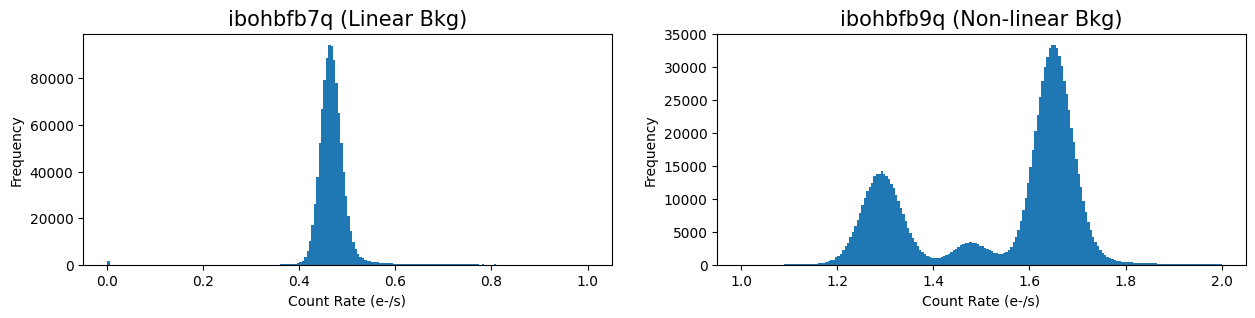

In [8]:
fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

n, bins, patches = ax1.hist(b7q_data.flatten(), bins=200, range=(0, 1))
n, bins, patches = ax2.hist(b9q_data.flatten(), bins=200, range=(1, 2))

ax1.set_title('ibohbfb7q (Linear Bkg)', fontsize=15)
ax1.set_xlabel('Count Rate (e-/s)')
ax1.set_ylabel('Frequency')

ax2.set_title('ibohbfb9q (Non-linear Bkg)', fontsize=15)
ax2.set_xlabel('Count Rate (e-/s)')
ax2.set_ylabel('Frequency')

Next, we use `pstat` in `wfc3tools` to plot statistics for the individual reads in each IMA file. 
Here, we plot the midpoint of each read in units of count rate. For the first image, the background is relatively constant throughout the exposure at 0.5 e/s. In the second image, the background quickly increases from a value of 0.5 e/s and levels off at ~1.5 e/s toward the end of the exposure. 

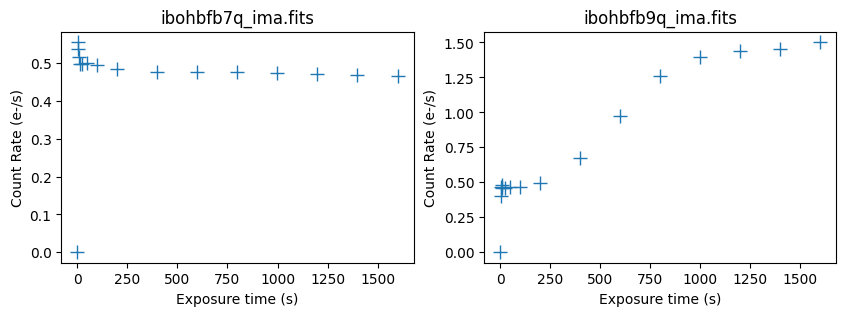

In [9]:
imafiles = ('ibohbfb7q_ima.fits', 'ibohbfb9q_ima.fits')
fig, axarr = plt.subplots(1, 2)
axarr = axarr.reshape(-1)
fig.set_size_inches(10, 3)
fig.set_dpi(100)

for i, ima in enumerate(imafiles):
    time, counts = pstat(ima, stat='midpt', units='rate', plot=False)
    axarr[i].plot(time, counts, '+', markersize=10)
    axarr[i].set_title(ima)
    axarr[i].set_xlabel('Exposure time (s)')
    axarr[i].set_ylabel('Count Rate (e-/s)')

To reprocess this image, we set the value of the header keyword CRCORR to "OMIT". This will perform all steps in the calibration pipeline except for the ramp fitting.  To see the current value of CRCORR, we use `astropy.io.fits.getval( ) `.

In [10]:
fits.getval('ibohbfb9q_raw.fits', 'CRCORR', 0)

'PERFORM'

Next, we edit the primary image header of the raw file to reflect the new value of CRCORR.

In [11]:
fits.setval('ibohbfb9q_raw.fits', 'CRCORR', value='OMIT')

Before running `calwf3`, we move the original pipeline products to a directory called `orig/`.

In [12]:
os.makedirs('orig/', exist_ok=True)

for file_pattern in ['ibohbf*_ima.fits', 'ibohbf*_flt.fits', 'ibohbf*_drz.fits']:
    for file in glob.glob(file_pattern):
        destination_path = os.path.join('orig', os.path.basename(file))
        if os.path.isfile(destination_path):
            os.remove(destination_path)
        shutil.move(file, destination_path)  

Finally, we run `calwf3` on the single raw exposure.

In [13]:
calwf3('ibohbfb9q_raw.fits')

git tag: e0988181-dirty

git branch: HEAD

HEAD @: e098818105734475101120a544dfe468207bc690





CALBEG*** CALWF3 -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:21 UTC





Input    ibohbfb9q_raw.fits

loading asn



LoadAsn:  Processing SINGLE exposure

Trying to open ibohbfb9q_raw.fits...

Read in Primary header from ibohbfb9q_raw.fits...

Creating new trailer file `ibohbfb9q.tra'.





CALBEG*** WF3IR -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:21 UTC

Input    ibohbfb9q_raw.fits

Output   ibohbfb9q_flt.fits

Trying to open ibohbfb9q_raw.fits...

Read in Primary header from ibohbfb9q_raw.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfb9q_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

   

ZSIGCORR detected 1285 saturated pixels in 0th read

ZSIGCORR detected 1349 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM

Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$u1k1727mi_lin.fits

NLINFILE PEDIGREE=INFLIGHT 09/02/2009 12/07/2009

NLINFILE DESCRIP =Non-linearity correction from WFC3 MEB1 TV3 and on-orbit frames----

NLINCORR detected 1285 saturated pixels in imset 16



NLINCORR detected 1354 saturated pixels in imset 15

NLINCORR detected 1381 saturated pixels in imset 14

NLINCORR detected 1388 saturated pixels in imset 13



NLINCORR detected 1395 saturated pixels in imset 12

NLINCORR detected 1413 saturated pixels in imset 11

NLINCORR detected 1433 saturated pixels in imset 10

NLINCORR detected 1466 saturated pixels in imset 9



NLINCORR detected 1502 saturated pixels in imset 8

NLINCORR detected 1561 saturated pixels in imset 7

NLINCORR detected 1671 saturated pixels in imset 6

NLINCORR detected 2295 saturated pixels in imset 5



NLINCORR detected 2916 saturated pixels in imset 4

NLINCORR detected 3206 saturated pixels in imset 3

NLINCORR detected 3328 saturated pixels in imset 2

NLINCORR detected 3400 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620245i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 20/09/2009 15/11/2016

DARKFILE DESCRIP =Dark Created from 154 frames spanning cycles 17 to 24--------------

DARKCORR using dark imset 16 for imset 16 with exptime=       0



DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229

DARKCORR using dark imset 14 for imset 14 with exptime= 5.86458



DARKCORR using dark imset 13 for imset 13 with exptime= 8.79687

DARKCORR using dark imset 12 for imset 12 with exptime= 11.7292



DARKCORR using dark imset 11 for imset 11 with exptime= 24.2297

DARKCORR using dark imset 10 for imset 10 with exptime= 49.2302



DARKCORR using dark imset  9 for imset  9 with exptime= 99.2306

DARKCORR using dark imset  8 for imset  8 with exptime= 199.231



DARKCORR using dark imset  7 for imset  7 with exptime= 399.231

DARKCORR using dark imset  6 for imset  6 with exptime= 599.232



DARKCORR using dark imset  5 for imset  5 with exptime= 799.232

DARKCORR using dark imset  4 for imset  4 with exptime= 999.232



DARKCORR using dark imset  3 for imset  3 with exptime= 1199.23

DARKCORR using dark imset  2 for imset  2 with exptime= 1399.23



DARKCORR using dark imset  1 for imset  1 with exptime= 1599.23

DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$4af1533ai_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 06/04/2012

IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------

NUMPAR=0, N=1

Allocated 1 parnames

==> Value of PHOTFLAM = 3.0507e-20

==> Value of PHOTPLAM = 10551.047

==> Value of PHOTBW = 845.61804

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   OMIT

FLATCORR PERFORM

PFLTFILE iref$4ac19225i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18263i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset



FLATCORR COMPLETE

Writing calibrated readouts to ibohbfb9q_ima.fits



Writing final image to ibohbfb9q_flt.fits

 with trimx = 5,5, trimy = 5,5





End      04-Sep-2024 17:52:25 UTC

*** WF3IR complete ***





End      04-Sep-2024 17:52:25 UTC

*** CALWF3 complete ***

CALWF3 completion for ibohbfb9q_raw.fits



The product will be a single calibrated IMA and FLT image. We now compare the original FLT and the reprocessed FLT for a small 200x200 pixel region of the detector. 

Text(0.5, 1.0, 'ibohbfb9q (Reprocessed)')

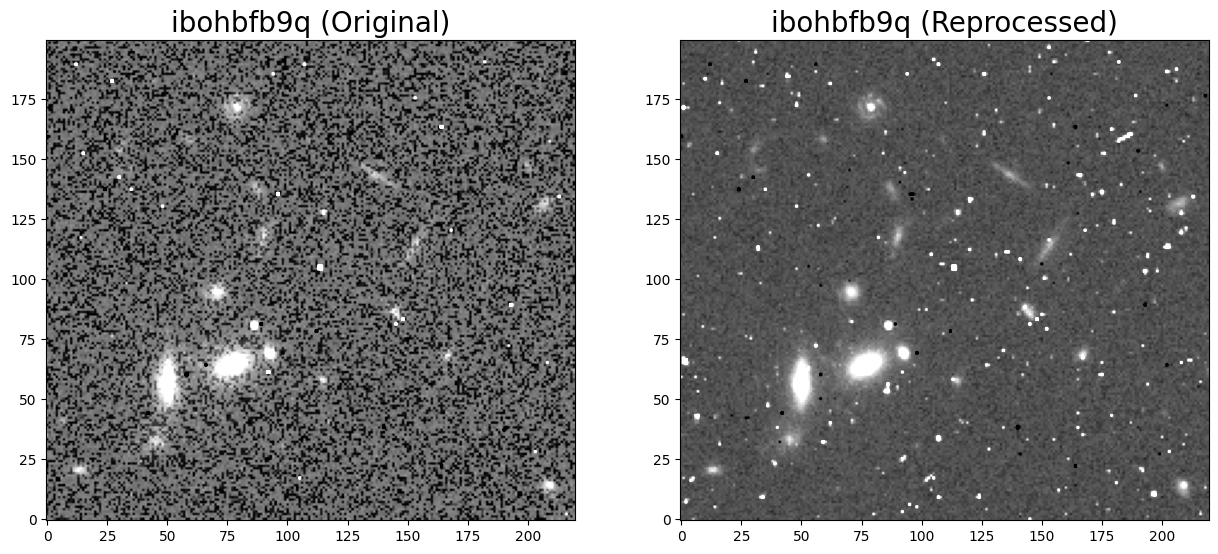

In [14]:
b9q_data = fits.getdata('orig/ibohbfb9q_flt.fits', ext=1)
b9q_newdata = fits.getdata('ibohbfb9q_flt.fits', ext=1)

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(b9q_data[520:720, 750:970], vmin=1.25, vmax=2.25, cmap='Greys_r', origin='lower')
ax2.imshow(b9q_newdata[520:720, 750:970], vmin=1.25, vmax=2.25, cmap='Greys_r', origin='lower')

ax1.set_title('ibohbfb9q (Original)', fontsize=20)
ax2.set_title('ibohbfb9q (Reprocessed)', fontsize=20)

Here we plot the image histogram showing the background in the original and reprocessed images.

Text(0, 0.5, 'Frequency')

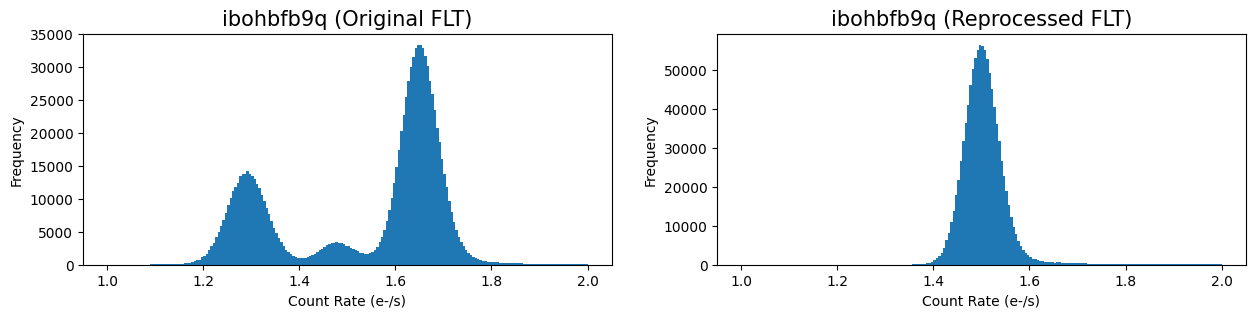

In [15]:
fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

n, bins, patches = ax1.hist(b9q_data.flatten(), bins=200, range=(1, 2))
n, bins, patches = ax2.hist(b9q_newdata.flatten(), bins=200, range=(1, 2))

ax1.set_title('ibohbfb9q (Original FLT)', fontsize=15)
ax1.set_xlabel('Count Rate (e-/s)')
ax1.set_ylabel('Frequency')

ax2.set_title('ibohbfb9q (Reprocessed FLT)', fontsize=15)
ax2.set_xlabel('Count Rate (e-/s)')
ax2.set_ylabel('Frequency')

The non-gaussian image histogram is now corrected in the reprocessed FLT and the distribution is centered at a mean background of 1.5 e/s. One caveat of this approach is that cosmic-rays are not cleaned in the reprocessed image and will need to be corrected when combining the six FLT frames with AstroDrizzle. This is demonstrated in the next example.

<a id="exec2"></a>
## 5. Reprocess multiple exposures in an association

In this example, we inspect the other images in the association to determine which are impacted by time-variable background, and we reprocess all six images with `calwf3` and `astrodrizzle`.  

Again, we list the contents of the association (asn) table.

In [16]:
dat = fits.getdata('ibohbf040_asn.fits', 1)
dat

FITS_rec([('IBOHBFB7Q', 'EXP-DTH',  1), ('IBOHBFB9Q', 'EXP-DTH',  1),
          ('IBOHBFBDQ', 'EXP-DTH',  1), ('IBOHBFBGQ', 'EXP-DTH',  1),
          ('IBOHBFBKQ', 'EXP-DTH',  1), ('IBOHBFBPQ', 'EXP-DTH',  1),
          ('IBOHBF040', 'PROD-DTH',  1)],
         dtype=(numpy.record, [('MEMNAME', 'S14'), ('MEMTYPE', 'S14'), ('MEMPRSNT', 'i1')]))

We can also print only the rootnames (ipppssoots) in the association.

In [17]:
dat['MEMNAME']

chararray(['IBOHBFB7Q', 'IBOHBFB9Q', 'IBOHBFBDQ', 'IBOHBFBGQ',
           'IBOHBFBKQ', 'IBOHBFBPQ', 'IBOHBF040'], dtype='<U14')

Using `pstat`, we can identify which of the six images are impacted by time-variable background.

Individual exposures b9q, bgq, and bkq show signs of strong time-variable background, where the change is more than a factor of 2. We will turn off the ramp fitting for these images and rerun `calwf3`.  

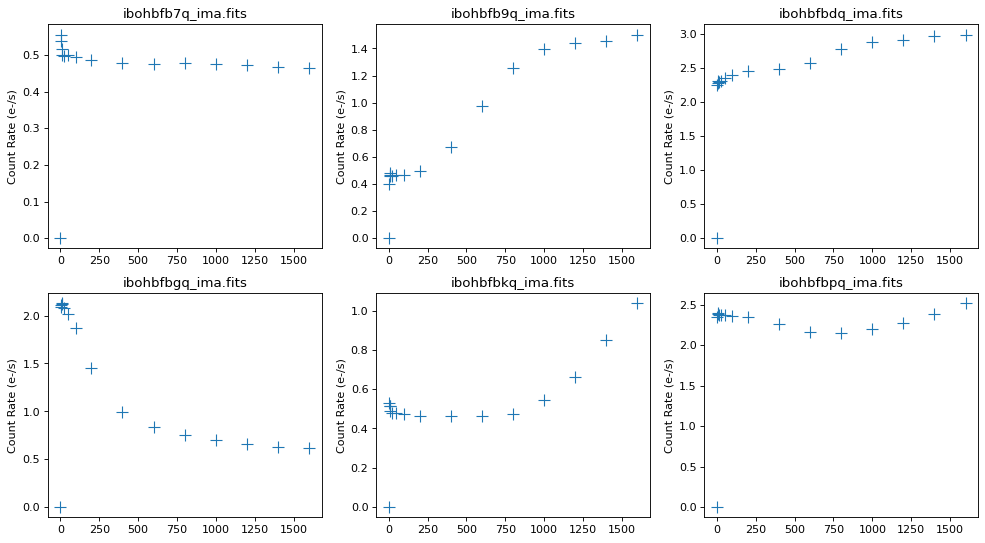

In [18]:
imafiles = sorted(glob.glob('orig/*ima.fits'))
fig, axarr = plt.subplots(2, 3)
axarr = axarr.reshape(-1)
fig.set_size_inches(15, 8)
fig.set_dpi(80)

for i, ima in enumerate(imafiles):
    time, counts = pstat(ima, stat='midpt', units='rate', plot=False)
    axarr[i].plot(time, counts, '+', markersize=10)
    axarr[i].set_title(ima[5:], fontsize=12)
    axarr[i].set_ylabel('Count Rate (e-/s)')

Here we edit the primary image header of the three RAW images to set CRCORR to the value OMIT.

In [19]:
for rawfile in ['ibohbfb9q_raw.fits', 'ibohbfbgq_raw.fits', 'ibohbfbkq_raw.fits']:
    fits.setval(rawfile, 'CRCORR', value='OMIT')

Next, we remove the calibrated products from the first example and then run `calwf3` on the image association. 

In [20]:
os.remove('ibohbfb9q_ima.fits')
os.remove('ibohbfb9q_flt.fits')

In [21]:
calwf3('ibohbf040_asn.fits')

# Alternatively, calwf3 may be run on a list of RAW files rather than the ASN

# for raws in glob.glob('ibohbf*_raw.fits'):
#     calwf3(raws)

git tag: e0988181-dirty

git branch: HEAD

HEAD @: e098818105734475101120a544dfe468207bc690





CALBEG*** CALWF3 -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:29 UTC





Input    ibohbf040_asn.fits

loading asn



LoadAsn:  Processing FULL Association

Trying to open ibohbf040_asn.fits...

Read in Primary header from ibohbf040_asn.fits...

Creating new trailer file `ibohbfb7q.tra'.





CALBEG*** WF3IR -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:29 UTC

Input    ibohbfb7q_raw.fits

Output   ibohbfb7q_flt.fits

Trying to open ibohbfb7q_raw.fits...

Read in Primary header from ibohbfb7q_raw.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfb7q_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

  

ZSIGCORR detected 1285 saturated pixels in 0th read

ZSIGCORR detected 1348 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM

Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$u1k1727mi_lin.fits

NLINFILE PEDIGREE=INFLIGHT 09/02/2009 12/07/2009

NLINFILE DESCRIP =Non-linearity correction from WFC3 MEB1 TV3 and on-orbit frames----

NLINCORR detected 1285 saturated pixels in imset 16



NLINCORR detected 1351 saturated pixels in imset 15

NLINCORR detected 1377 saturated pixels in imset 14

NLINCORR detected 1382 saturated pixels in imset 13



NLINCORR detected 1389 saturated pixels in imset 12

NLINCORR detected 1408 saturated pixels in imset 11

NLINCORR detected 1424 saturated pixels in imset 10

NLINCORR detected 1458 saturated pixels in imset 9



NLINCORR detected 1498 saturated pixels in imset 8

NLINCORR detected 1548 saturated pixels in imset 7

NLINCORR detected 1601 saturated pixels in imset 6

NLINCORR detected 1648 saturated pixels in imset 5



NLINCORR detected 1685 saturated pixels in imset 4

NLINCORR detected 1737 saturated pixels in imset 3

NLINCORR detected 1799 saturated pixels in imset 2

NLINCORR detected 1859 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620245i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 20/09/2009 15/11/2016

DARKFILE DESCRIP =Dark Created from 154 frames spanning cycles 17 to 24--------------

DARKCORR using dark imset 16 for imset 16 with exptime=       0



DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229

DARKCORR using dark imset 14 for imset 14 with exptime= 5.86458



DARKCORR using dark imset 13 for imset 13 with exptime= 8.79687

DARKCORR using dark imset 12 for imset 12 with exptime= 11.7292



DARKCORR using dark imset 11 for imset 11 with exptime= 24.2297

DARKCORR using dark imset 10 for imset 10 with exptime= 49.2302



DARKCORR using dark imset  9 for imset  9 with exptime= 99.2306

DARKCORR using dark imset  8 for imset  8 with exptime= 199.231



DARKCORR using dark imset  7 for imset  7 with exptime= 399.231

DARKCORR using dark imset  6 for imset  6 with exptime= 599.232



DARKCORR using dark imset  5 for imset  5 with exptime= 799.232

DARKCORR using dark imset  4 for imset  4 with exptime= 999.232



DARKCORR using dark imset  3 for imset  3 with exptime= 1199.23

DARKCORR using dark imset  2 for imset  2 with exptime= 1399.23



DARKCORR using dark imset  1 for imset  1 with exptime= 1599.23

DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$4af1533ai_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 06/04/2012

IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------

NUMPAR=0, N=1

Allocated 1 parnames

==> Value of PHOTFLAM = 3.0507e-20

==> Value of PHOTPLAM = 10551.047

==> Value of PHOTBW = 845.61804

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   PERFORM

CRREJTAB iref$u6a1748ri_crr.fits

CRIDCALC using 4 sigma rejection threshold

               256 bad DQ mask

               4 max CRs for UNSTABLE



89 pixels detected as unstable

CRCORR   COMPLETE

FLATCORR PERFORM

PFLTFILE iref$4ac19225i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18263i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset

FLATCORR COMPLETE

Writing calibrated readouts to ibohbfb7q_ima.fits



Writing final image to ibohbfb7q_flt.fits

 with trimx = 5,5, trimy = 5,5





End      04-Sep-2024 17:52:34 UTC

*** WF3IR complete ***

RPTCORR  OMIT

Revising existing trailer file `ibohbfb9q.tra'.





CALBEG*** WF3IR -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:34 UTC

Input    ibohbfb9q_raw.fits

Output   ibohbfb9q_flt.fits

Trying to open ibohbfb9q_raw.fits...

Read in Primary header from ibohbfb9q_raw.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfb9q_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

    gain =2.34,2.37,2.31,2.38

DQICORR  PERFORM

DQITAB   iref$3562033hi_bpx.fits

DQITAB   PEDIGREE=INFLIGHT 01/11/2012 12/10/2013

DQITAB   DESCRIP =Bad Pixel Table generated using Cycle 20 Flats and Dar

ZSIGCORR PERFORM

ZSIGCORR detected 1285 saturated pixels in 0th read

ZSIGCORR detected 1349 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM

Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$u1k1727mi_lin.fits

NLINFILE PEDIGREE=INFLIGHT 09/02/2009 12/07/2009

NLINFILE DESCRIP =Non-linearity correction from WFC3 MEB1 TV3 and on-orbit frames----



NLINCORR detected 1285 saturated pixels in imset 16

NLINCORR detected 1354 saturated pixels in imset 15

NLINCORR detected 1381 saturated pixels in imset 14



NLINCORR detected 1388 saturated pixels in imset 13

NLINCORR detected 1395 saturated pixels in imset 12

NLINCORR detected 1413 saturated pixels in imset 11

NLINCORR detected 1433 saturated pixels in imset 10



NLINCORR detected 1466 saturated pixels in imset 9

NLINCORR detected 1502 saturated pixels in imset 8

NLINCORR detected 1561 saturated pixels in imset 7

NLINCORR detected 1671 saturated pixels in imset 6



NLINCORR detected 2295 saturated pixels in imset 5

NLINCORR detected 2916 saturated pixels in imset 4

NLINCORR detected 3206 saturated pixels in imset 3

NLINCORR detected 3328 saturated pixels in imset 2



NLINCORR detected 3400 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620245i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 20/09/2009 15/11/2016

DARKFILE DESCRIP =Dark Created from 154 frames spanning cycles 17 to 24--------------

DARKCORR using dark imset 16 for imset 16 with exptime=       0

DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229

DARKCORR using dark imset 14 for imset 14 with exptime= 5.86458



DARKCORR using dark imset 13 for imset 13 with exptime= 8.79687

DARKCORR using dark imset 12 for imset 12 with exptime= 11.7292



DARKCORR using dark imset 11 for imset 11 with exptime= 24.2297

DARKCORR using dark imset 10 for imset 10 with exptime= 49.2302



DARKCORR using dark imset  9 for imset  9 with exptime= 99.2306

DARKCORR using dark imset  8 for imset  8 with exptime= 199.231



DARKCORR using dark imset  7 for imset  7 with exptime= 399.231

DARKCORR using dark imset  6 for imset  6 with exptime= 599.232



DARKCORR using dark imset  5 for imset  5 with exptime= 799.232

DARKCORR using dark imset  4 for imset  4 with exptime= 999.232



DARKCORR using dark imset  3 for imset  3 with exptime= 1199.23

DARKCORR using dark imset  2 for imset  2 with exptime= 1399.23



DARKCORR using dark imset  1 for imset  1 with exptime= 1599.23

DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$4af1533ai_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 06/04/2012

IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------

NUMPAR=0, N=1

Allocated 1 parnames

==> Value of PHOTFLAM = 3.0507e-20

==> Value of PHOTPLAM = 10551.047

==> Value of PHOTBW = 845.61804

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   OMIT

FLATCORR PERFORM

PFLTFILE iref$4ac19225i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18263i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset



FLATCORR COMPLETE

Writing calibrated readouts to ibohbfb9q_ima.fits



Writing final image to ibohbfb9q_flt.fits

 with trimx = 5,5, trimy = 5,5





End      04-Sep-2024 17:52:38 UTC

*** WF3IR complete ***

RPTCORR  OMIT

Creating new trailer file `ibohbfbdq.tra'.





CALBEG*** WF3IR -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:38 UTC

Input    ibohbfbdq_raw.fits

Output   ibohbfbdq_flt.fits

Trying to open ibohbfbdq_raw.fits...

Read in Primary header from ibohbfbdq_raw.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfbdq_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

    gain =2.34,2.37,2.31,2.38

DQICORR  PERFORM

DQITAB   iref$3562033hi_bpx.fits

DQITAB   PEDIGREE=INFLIGHT 01/11/2012 12/10/2013

DQITAB   DESCRIP =Bad Pixel Table generated using Cycle 20 Flats and Darks---

ZSIGCORR PERFORM

ZSIGCORR detected 1285 saturated pixels in 0th read

ZSIGCORR detected 1347 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM

Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$u1k1727mi_lin.fits

NLINFILE PEDIGREE=INFLIGHT 09/02/2009 12/07/2009

NLINFILE DESCRIP =Non-linearity correction from WFC3 MEB1 TV3 and on-orbit frames----



NLINCORR detected 1285 saturated pixels in imset 16

NLINCORR detected 1350 saturated pixels in imset 15

NLINCORR detected 1377 saturated pixels in imset 14

NLINCORR detected 1386 saturated pixels in imset 13



NLINCORR detected 1391 saturated pixels in imset 12

NLINCORR detected 1419 saturated pixels in imset 11

NLINCORR detected 1436 saturated pixels in imset 10

NLINCORR detected 1474 saturated pixels in imset 9



NLINCORR detected 1554 saturated pixels in imset 8

NLINCORR detected 2226 saturated pixels in imset 7

NLINCORR detected 3004 saturated pixels in imset 6

NLINCORR detected 3323 saturated pixels in imset 5



NLINCORR detected 3371 saturated pixels in imset 4

NLINCORR detected 3396 saturated pixels in imset 3

NLINCORR detected 3413 saturated pixels in imset 2

NLINCORR detected 3434 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620245i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 20/09/2009 15/11/2016

DARKFILE DESCRIP =Dark Created from 154 frames spanning cycles 17 to 24--------------

DARKCORR using dark imset 16 for imset 16 with exptime=       0



DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229

DARKCORR using dark imset 14 for imset 14 with exptime= 5.86458



DARKCORR using dark imset 13 for imset 13 with exptime= 8.79687

DARKCORR using dark imset 12 for imset 12 with exptime= 11.7292



DARKCORR using dark imset 11 for imset 11 with exptime= 24.2297

DARKCORR using dark imset 10 for imset 10 with exptime= 49.2302



DARKCORR using dark imset  9 for imset  9 with exptime= 99.2306

DARKCORR using dark imset  8 for imset  8 with exptime= 199.231



DARKCORR using dark imset  7 for imset  7 with exptime= 399.231

DARKCORR using dark imset  6 for imset  6 with exptime= 599.232



DARKCORR using dark imset  5 for imset  5 with exptime= 799.232

DARKCORR using dark imset  4 for imset  4 with exptime= 999.232



DARKCORR using dark imset  3 for imset  3 with exptime= 1199.23

DARKCORR using dark imset  2 for imset  2 with exptime= 1399.23



DARKCORR using dark imset  1 for imset  1 with exptime= 1599.23

DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$4af1533ai_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 06/04/2012

IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------

NUMPAR=0, N=1

Allocated 1 parnames

==> Value of PHOTFLAM = 3.0507e-20

==> Value of PHOTPLAM = 10551.047

==> Value of PHOTBW = 845.61804

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   PERFORM

CRREJTAB iref$u6a1748ri_crr.fits

CRIDCALC using 4 sigma rejection threshold

               256 bad DQ mask

               4 max CRs for UNSTABLE



53 pixels detected as unstable

CRCORR   COMPLETE

FLATCORR PERFORM

PFLTFILE iref$4ac19225i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18263i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset

FLATCORR COMPLETE

Writing calibrated readouts to ibohbfbdq_ima.fits



Writing final image to ibohbfbdq_flt.fits

 with trimx = 5,5, trimy = 5,5





End      04-Sep-2024 17:52:43 UTC

*** WF3IR complete ***

RPTCORR  OMIT

Creating new trailer file `ibohbfbgq.tra'.





CALBEG*** WF3IR -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:43 UTC

Input    ibohbfbgq_raw.fits

Output   ibohbfbgq_flt.fits

Trying to open ibohbfbgq_raw.fits...

Read in Primary header from ibohbfbgq_raw.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfbgq_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

    gain =2.34,2.37,2.31,2.38

DQICORR  PERFORM

DQITAB   iref$3562033hi_bpx.fits

DQITAB   PEDIGREE=INFLIGHT 01/11/2012 12/10/2013

DQITAB   DESCRIP =Bad Pixel Table generated using Cycle 20 Flats and Darks---

ZSIGCORR PERFORM

ZSIGCORR detected 1285 saturated pixels in 0th read

ZSIGCORR detected 1345 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM



Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$u1k1727mi_lin.fits

NLINFILE PEDIGREE=INFLIGHT 09/02/2009 12/07/2009

NLINFILE DESCRIP =Non-linearity correction from WFC3 MEB1 TV3 and on-orbit frames----

NLINCORR detected 1285 saturated pixels in imset 16

NLINCORR detected 1347 saturated pixels in imset 15



NLINCORR detected 1375 saturated pixels in imset 14

NLINCORR detected 1381 saturated pixels in imset 13

NLINCORR detected 1387 saturated pixels in imset 12

NLINCORR detected 1404 saturated pixels in imset 11



NLINCORR detected 1423 saturated pixels in imset 10

NLINCORR detected 1460 saturated pixels in imset 9

NLINCORR detected 1494 saturated pixels in imset 8

NLINCORR detected 1540 saturated pixels in imset 7



NLINCORR detected 1572 saturated pixels in imset 6

NLINCORR detected 1615 saturated pixels in imset 5

NLINCORR detected 1632 saturated pixels in imset 4

NLINCORR detected 1647 saturated pixels in imset 3



NLINCORR detected 1662 saturated pixels in imset 2

NLINCORR detected 1680 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620245i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 20/09/2009 15/11/2016

DARKFILE DESCRIP =Dark Created from 154 frames spanning cycles 17 to 24--------------

DARKCORR using dark imset 16 for imset 16 with exptime=       0

DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229



DARKCORR using dark imset 14 for imset 14 with exptime= 5.86458

DARKCORR using dark imset 13 for imset 13 with exptime= 8.79687



DARKCORR using dark imset 12 for imset 12 with exptime= 11.7292

DARKCORR using dark imset 11 for imset 11 with exptime= 24.2297



DARKCORR using dark imset 10 for imset 10 with exptime= 49.2302

DARKCORR using dark imset  9 for imset  9 with exptime= 99.2306



DARKCORR using dark imset  8 for imset  8 with exptime= 199.231

DARKCORR using dark imset  7 for imset  7 with exptime= 399.231



DARKCORR using dark imset  6 for imset  6 with exptime= 599.232

DARKCORR using dark imset  5 for imset  5 with exptime= 799.232



DARKCORR using dark imset  4 for imset  4 with exptime= 999.232

DARKCORR using dark imset  3 for imset  3 with exptime= 1199.23



DARKCORR using dark imset  2 for imset  2 with exptime= 1399.23

DARKCORR using dark imset  1 for imset  1 with exptime= 1599.23



DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$4af1533ai_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 06/04/2012

IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------

NUMPAR=0, N=1

Allocated 1 parnames

==> Value of PHOTFLAM = 3.0507e-20

==> Value of PHOTPLAM = 10551.047

==> Value of PHOTBW = 845.61804

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   OMIT

FLATCORR PERFORM

PFLTFILE iref$4ac19225i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18263i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset

FLATCORR COMPLETE



Writing calibrated readouts to ibohbfbgq_ima.fits



Writing final image to ibohbfbgq_flt.fits

 with trimx = 5,5, trimy = 5,5





End      04-Sep-2024 17:52:47 UTC

*** WF3IR complete ***

RPTCORR  OMIT

Creating new trailer file `ibohbfbkq.tra'.





CALBEG*** WF3IR -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:47 UTC

Input    ibohbfbkq_raw.fits

Output   ibohbfbkq_flt.fits

Trying to open ibohbfbkq_raw.fits...

Read in Primary header from ibohbfbkq_raw.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfbkq_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

    gain =2.34,2.37,2.31,2.38

DQICORR  PERFORM

DQITAB   iref$3562033hi_bpx.fits

DQITAB   PEDIGREE=INFLIGHT 01/11/2012 12/10/2013

DQITAB   DESCRIP =Bad Pixel Table generated using Cycle 20 Flats and Darks---

ZSIGCORR PERFORM

ZSIGCORR detected 1285 saturated pixels in 0th read

ZSIGCORR detected 1346 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM



Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$u1k1727mi_lin.fits

NLINFILE PEDIGREE=INFLIGHT 09/02/2009 12/07/2009

NLINFILE DESCRIP =Non-linearity correction from WFC3 MEB1 TV3 and on-orbit frames----

NLINCORR detected 1285 saturated pixels in imset 16

NLINCORR detected 1350 saturated pixels in imset 15



NLINCORR detected 1377 saturated pixels in imset 14

NLINCORR detected 1384 saturated pixels in imset 13

NLINCORR detected 1389 saturated pixels in imset 12



NLINCORR detected 1406 saturated pixels in imset 11

NLINCORR detected 1428 saturated pixels in imset 10

NLINCORR detected 1459 saturated pixels in imset 9

NLINCORR detected 1490 saturated pixels in imset 8



NLINCORR detected 1530 saturated pixels in imset 7

NLINCORR detected 1568 saturated pixels in imset 6

NLINCORR detected 1597 saturated pixels in imset 5

NLINCORR detected 1624 saturated pixels in imset 4



NLINCORR detected 1648 saturated pixels in imset 3

NLINCORR detected 1683 saturated pixels in imset 2

NLINCORR detected 1862 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620245i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 20/09/2009 15/11/2016

DARKFILE DESCRIP =Dark Created from 154 frames spanning cycles 17 to 24--------------

DARKCORR using dark imset 16 for imset 16 with exptime=       0

DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229



DARKCORR using dark imset 14 for imset 14 with exptime= 5.86458

DARKCORR using dark imset 13 for imset 13 with exptime= 8.79687



DARKCORR using dark imset 12 for imset 12 with exptime= 11.7292

DARKCORR using dark imset 11 for imset 11 with exptime= 24.2297



DARKCORR using dark imset 10 for imset 10 with exptime= 49.2302

DARKCORR using dark imset  9 for imset  9 with exptime= 99.2306



DARKCORR using dark imset  8 for imset  8 with exptime= 199.231

DARKCORR using dark imset  7 for imset  7 with exptime= 399.231



DARKCORR using dark imset  6 for imset  6 with exptime= 599.232

DARKCORR using dark imset  5 for imset  5 with exptime= 799.232



DARKCORR using dark imset  4 for imset  4 with exptime= 999.232

DARKCORR using dark imset  3 for imset  3 with exptime= 1199.23



DARKCORR using dark imset  2 for imset  2 with exptime= 1399.23

DARKCORR using dark imset  1 for imset  1 with exptime= 1599.23



DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$4af1533ai_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 06/04/2012

IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------

NUMPAR=0, N=1

Allocated 1 parnames

==> Value of PHOTFLAM = 3.0507e-20

==> Value of PHOTPLAM = 10551.047

==> Value of PHOTBW = 845.61804

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   OMIT

FLATCORR PERFORM

PFLTFILE iref$4ac19225i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18263i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset

FLATCORR COMPLETE



Writing calibrated readouts to ibohbfbkq_ima.fits



Writing final image to ibohbfbkq_flt.fits

 with trimx = 5,5, trimy = 5,5





End      04-Sep-2024 17:52:51 UTC

*** WF3IR complete ***

RPTCORR  OMIT

Creating new trailer file `ibohbfbpq.tra'.





CALBEG*** WF3IR -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:51 UTC

Input    ibohbfbpq_raw.fits

Output   ibohbfbpq_flt.fits

Trying to open ibohbfbpq_raw.fits...

Read in Primary header from ibohbfbpq_raw.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfbpq_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

    gain =2.34,2.37,2.31,2.38

DQICORR  PERFORM

DQITAB   iref$3562033hi_bpx.fits

DQITAB   PEDIGREE=INFLIGHT 01/11/2012 12/10/2013

DQITAB   DESCRIP =Bad Pixel Table generated using Cycle 20 Flats and Darks---

ZSIGCORR PERFORM

ZSIGCORR detected 1285 saturated pixels in 0th read

ZSIGCORR detected 1347 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM



Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$u1k1727mi_lin.fits

NLINFILE PEDIGREE=INFLIGHT 09/02/2009 12/07/2009

NLINFILE DESCRIP =Non-linearity correction from WFC3 MEB1 TV3 and on-orbit frames----

NLINCORR detected 1285 saturated pixels in imset 16

NLINCORR detected 1351 saturated pixels in imset 15



NLINCORR detected 1378 saturated pixels in imset 14

NLINCORR detected 1382 saturated pixels in imset 13

NLINCORR detected 1390 saturated pixels in imset 12

NLINCORR detected 1409 saturated pixels in imset 11



NLINCORR detected 1426 saturated pixels in imset 10

NLINCORR detected 1463 saturated pixels in imset 9

NLINCORR detected 1507 saturated pixels in imset 8

NLINCORR detected 1634 saturated pixels in imset 7



NLINCORR detected 1980 saturated pixels in imset 6

NLINCORR detected 2560 saturated pixels in imset 5

NLINCORR detected 3029 saturated pixels in imset 4

NLINCORR detected 3278 saturated pixels in imset 3



NLINCORR detected 3359 saturated pixels in imset 2

NLINCORR detected 3392 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620245i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 20/09/2009 15/11/2016

DARKFILE DESCRIP =Dark Created from 154 frames spanning cycles 17 to 24--------------

DARKCORR using dark imset 16 for imset 16 with exptime=       0

DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229



DARKCORR using dark imset 14 for imset 14 with exptime= 5.86458

DARKCORR using dark imset 13 for imset 13 with exptime= 8.79687



DARKCORR using dark imset 12 for imset 12 with exptime= 11.7292

DARKCORR using dark imset 11 for imset 11 with exptime= 24.2297



DARKCORR using dark imset 10 for imset 10 with exptime= 49.2302

DARKCORR using dark imset  9 for imset  9 with exptime= 99.2306



DARKCORR using dark imset  8 for imset  8 with exptime= 199.231

DARKCORR using dark imset  7 for imset  7 with exptime= 399.231



DARKCORR using dark imset  6 for imset  6 with exptime= 599.232

DARKCORR using dark imset  5 for imset  5 with exptime= 799.232



DARKCORR using dark imset  4 for imset  4 with exptime= 999.232

DARKCORR using dark imset  3 for imset  3 with exptime= 1199.23



DARKCORR using dark imset  2 for imset  2 with exptime= 1399.23

DARKCORR using dark imset  1 for imset  1 with exptime= 1599.23



DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$4af1533ai_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 06/04/2012

IMPHTTAB DESCRIP =photometry keywords reference file---------------------------------

NUMPAR=0, N=1

Allocated 1 parnames

==> Value of PHOTFLAM = 3.0507e-20

==> Value of PHOTPLAM = 10551.047

==> Value of PHOTBW = 845.61804

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   PERFORM

CRREJTAB iref$u6a1748ri_crr.fits

CRIDCALC using 4 sigma rejection threshold

               256 bad DQ mask

               4 max CRs for UNSTABLE



65 pixels detected as unstable

CRCORR   COMPLETE

FLATCORR PERFORM

PFLTFILE iref$4ac19225i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18263i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset

FLATCORR COMPLETE

Writing calibrated readouts to ibohbfbpq_ima.fits



Writing final image to ibohbfbpq_flt.fits

 with trimx = 5,5, trimy = 5,5





End      04-Sep-2024 17:52:56 UTC

*** WF3IR complete ***

RPTCORR  OMIT





CALBEG*** WF3DTH -- Version 3.7.1 (Oct-18-2023) ***

Begin    04-Sep-2024 17:52:56 UTC

Astrodrizzle needs to be run in order to generate

a geometrically corrected, drizzle-combined product.

Warning    Can't find input file "ibohbfb7q_spt.fits"

Warning    Can't find input file "ibohbfb9q_spt.fits"

Warning    Can't find input file "ibohbfbdq_spt.fits"

Warning    Can't find input file "ibohbfbgq_spt.fits"

Warning    Can't find input file "ibohbfbkq_spt.fits"

Warning    Can't find input file "ibohbfbpq_spt.fits"

End      04-Sep-2024 17:52:56 UTC

*** WF3DTH complete ***

Trying to open ibohbf040_asn.fits...

Updated Global Header for ibohbf040_asn.fits...





End      04-Sep-2024 17:52:56 UTC

*** CALWF3 complete ***

CALWF3 completion for ibohbf040_asn.fits



Finally we combine the reprocessed FLTs with AstroDrizzle.

First, the World Coordinate System (WCS) of the calibrated images must be updated using `updatewcs`. This prepares the image for `astrodrizzle` to apply the various components of geometric distortion correction. 

When the parameter `use_db=False`, the WCS will be based on the coordinates of the Guide Star Catalogs in use at the time. No realignment of the images is performed, and this typically gives the best 'relative' astrometry between exposures in a visit, either in the same filter or across multiple filters. 

When `use_db=True`, the software will connect to the astrometry database and update the WCS to an absolute frame of reference, typically based on an external catalog such as Gaia. Here, the quality of the fit is dependent on the number of bright sources in each image, and in some cased the relative astrometry may not be optimal. 

In [22]:
for flts in glob.glob('ibohbf*_flt.fits'):
    updatewcs.updatewcs(input=flts, use_db=False)          

- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W


- IDCTAB: Distortion model from row 1 for chip 1 : F105W


- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W


- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W


- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W


- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W


Next, we use AstroDrizzle to combine the FLT frames, making use of internal CR-flagging algorithms to clean the images. 

In [23]:
astrodrizzle.AstroDrizzle(input='ibohbf040_asn.fits', mdriztab=True, preserve=False, clean=True)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.7.1 started at: 17:52:57.174 (04/09/2024)


AstroDrizzle Version 3.7.1 started at: 17:52:57.174 (04/09/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version 3.11.9 (main, Jul 15 2024, 21:50:21) [GCC 11.4.0]


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.26.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 6.1.3 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.3 


INFO:drizzlepac.astrodrizzle:photutils Version -> 1.12.0 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  17:52:57.181 (04/09/2024)


==== Processing Step  Initialization  started at  17:52:57.181 (04/09/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: ibohbf040_drz.fits


INFO:drizzlepac.processInput:Reading in MDRIZTAB parameters for 6 files


Reading in MDRIZTAB parameters for 6 files


INFO:drizzlepac.mdzhandler:- MDRIZTAB: AstroDrizzle parameters read from row 3.


- MDRIZTAB: AstroDrizzle parameters read from row 3.


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibohbfb7q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibohbfb9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibohbfbdq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibohbfbgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibohbfbkq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibohbfbpq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


INFO:astropy.wcs.wcs:CRVAL : 189.12062959820963 62.23566816084302 


CRVAL : 189.12062959820963 62.23566816084302 


INFO:astropy.wcs.wcs:CRPIX : 546.5 482.0 


CRPIX : 546.5 482.0 


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.519072953429177e-05 2.5190629749066887e-05 


CD1_1 CD1_2  : 2.519072953429177e-05 2.5190629749066887e-05 


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 2.5190629749066887e-05 -2.519072953429177e-05 


CD2_1 CD2_2  : 2.5190629749066887e-05 -2.519072953429177e-05 


INFO:astropy.wcs.wcs:NAXIS : 1093  964


NAXIS : 1093  964


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 79 Mb.


*  Estimated memory usage:  up to 79 Mb.


INFO:drizzlepac.processInput:*  Output image size:       1093 X 964 pixels. 


*  Output image size:       1093 X 964 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 12 Mb. 


*  Output image file:       ~ 12 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         4


*  Cores available:         4


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 17:52:57.832 (04/09/2024)


==== Processing Step Initialization finished at 17:52:57.832 (04/09/2024)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	True


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	ibohbf040_asn.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	True


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	rules_file :	


INFO:drizzlepac.astrodrizzle:	runfile :	


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  17:52:57.842 (04/09/2024)


==== Processing Step  Static Mask  started at  17:52:57.842 (04/09/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.464496;   rms = 0.024783;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.496449;   rms = 0.038382;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  2.971131;   rms = 0.053467;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.610327;   rms = 0.027296;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.033340;   rms = 0.033693;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  2.475544;   rms = 0.053811;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step Static Mask finished at 17:52:57.943 (04/09/2024)


==== Processing Step Static Mask finished at 17:52:57.943 (04/09/2024)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  17:52:57.945 (04/09/2024)


==== Processing Step  Subtract Sky  started at  17:52:57.945 (04/09/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	16


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	-100.0


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	mode


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.10000000149011612


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2024-09-04 17:52:58.016603


***** skymatch started on 2024-09-04 17:52:58.016603


INFO:stsci.skypac.utils:      Version 1.0.10


      Version 1.0.10


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibohbfb7q_flt.fits'


   **  Input image: 'ibohbfb7q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibohbfb7q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibohbfb7q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibohbfb9q_flt.fits'


   **  Input image: 'ibohbfb9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibohbfb9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibohbfb9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibohbfbdq_flt.fits'


   **  Input image: 'ibohbfbdq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibohbfbdq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibohbfbdq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibohbfbgq_flt.fits'


   **  Input image: 'ibohbfbgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibohbfbgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibohbfbgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibohbfbkq_flt.fits'


   **  Input image: 'ibohbfbkq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibohbfbkq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibohbfbkq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibohbfbpq_flt.fits'


   **  Input image: 'ibohbfbpq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibohbfbpq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibohbfbpq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'mode'


       statistics function: 'mode'


INFO:stsci.skypac.utils:       lower = -100.0


       lower = -100.0


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.10000000149011612


       binwidth = 0.10000000149011612


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibohbfb7q_flt.fits


   *   Image: ibohbfb7q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711455


             Conversion factor (data->brightness):  60.797431635711455


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibohbfb9q_flt.fits


   *   Image: ibohbfb9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711455


             Conversion factor (data->brightness):  60.797431635711455


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibohbfbdq_flt.fits


   *   Image: ibohbfbdq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711455


             Conversion factor (data->brightness):  60.797431635711455


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibohbfbgq_flt.fits


   *   Image: ibohbfbgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711455


             Conversion factor (data->brightness):  60.797431635711455


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibohbfbkq_flt.fits


   *   Image: ibohbfbkq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711455


             Conversion factor (data->brightness):  60.797431635711455


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibohbfbpq_flt.fits


   *   Image: ibohbfbpq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711455


             Conversion factor (data->brightness):  60.797431635711455


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibohbfb7q_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibohbfb7q_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibohbfb9q_flt.fits['SCI',1]' SKY = 62.7621 [brightness units]


   *   Image 'ibohbfb9q_flt.fits['SCI',1]' SKY = 62.7621 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 1.03231


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 1.03231


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibohbfbdq_flt.fits['SCI',1]' SKY = 152.41 [brightness units]


   *   Image 'ibohbfbdq_flt.fits['SCI',1]' SKY = 152.41 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.50685


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.50685


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibohbfbgq_flt.fits['SCI',1]' SKY = 8.81763 [brightness units]


   *   Image 'ibohbfbgq_flt.fits['SCI',1]' SKY = 8.81763 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.145033


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.145033


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibohbfbkq_flt.fits['SCI',1]' SKY = 34.5068 [brightness units]


   *   Image 'ibohbfbkq_flt.fits['SCI',1]' SKY = 34.5068 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.56757


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.56757


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibohbfbpq_flt.fits['SCI',1]' SKY = 122.233 [brightness units]


   *   Image 'ibohbfbpq_flt.fits['SCI',1]' SKY = 122.233 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.01049


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 2.01049


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2024-09-04 17:53:05.482805


***** skymatch ended on 2024-09-04 17:53:05.482805


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:07.466202


TOTAL RUN TIME: 0:00:07.466202


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 17:53:05.548 (04/09/2024)


==== Processing Step Subtract Sky finished at 17:53:05.548 (04/09/2024)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  17:53:05.550 (04/09/2024)


==== Processing Step  Separate Drizzle  started at  17:53:05.550 (04/09/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': 'INDEF', 'bits': 528, 'compress': False, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	528


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	compress :	False


INFO:drizzlepac.adrizzle:	crbit :	None


INFO:drizzlepac.adrizzle:	fillval :	INDEF


INFO:drizzlepac.adrizzle:	kernel :	turbo


INFO:drizzlepac.adrizzle:	num_cores :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	electrons


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	None


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel turbo


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


INFO:astropy.wcs.wcs:CRVAL : 189.12062959820963 62.23566816084302 


CRVAL : 189.12062959820963 62.23566816084302 


INFO:astropy.wcs.wcs:CRPIX : 546.5 482.0 


CRPIX : 546.5 482.0 


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.519072953429177e-05 2.5190629749066887e-05 


CD1_1 CD1_2  : 2.519072953429177e-05 2.5190629749066887e-05 


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 2.5190629749066887e-05 -2.519072953429177e-05 


CD2_1 CD2_2  : 2.5190629749066887e-05 -2.519072953429177e-05 


INFO:astropy.wcs.wcs:NAXIS : 1093  964


NAXIS : 1093  964


INFO:drizzlepac.adrizzle:Executing 4 parallel workers


INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfb7q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfb9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibohbfb7q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfbdq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfbgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:Applying sky value of 1.032315 to ibohbfb9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.adrizzle:Applying sky value of 2.506848 to ibohbfbdq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.adrizzle:Applying sky value of 0.145033 to ibohbfbgq_flt.fits[sci,1]


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfb7q_single_sci.fits


-Generating simple FITS output: ibohbfb7q_single_sci.fits


  warnings.warn(



INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfb9q_single_sci.fits


-Generating simple FITS output: ibohbfb9q_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfbdq_single_sci.fits


-Generating simple FITS output: ibohbfbdq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfbgq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfb7q_single_sci.fits


Writing out image to disk: ibohbfb7q_single_sci.fits


-Generating simple FITS output: ibohbfbgq_single_sci.fits


  warnings.warn(



  warnings.warn(



  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfb9q_single_sci.fits


Writing out image to disk: ibohbfb9q_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbdq_single_sci.fits


Writing out image to disk: ibohbfbdq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbgq_single_sci.fits


Writing out image to disk: ibohbfbgq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfb7q_single_wht.fits


Writing out image to disk: ibohbfb7q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbdq_single_wht.fits


Writing out image to disk: ibohbfbdq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfb9q_single_wht.fits


Writing out image to disk: ibohbfb9q_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbgq_single_wht.fits


Writing out image to disk: ibohbfbgq_single_wht.fits


INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfbkq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfbpq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.567570 to ibohbfbkq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.010493 to ibohbfbpq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo



INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfbpq_single_sci.fits


-Generating simple FITS output: ibohbfbpq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfbkq_single_sci.fits


-Generating simple FITS output: ibohbfbkq_single_sci.fits


  warnings.warn(



  warnings.warn(



INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbkq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbpq_single_sci.fits


Writing out image to disk: ibohbfbkq_single_sci.fits


Writing out image to disk: ibohbfbpq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbpq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbkq_single_wht.fits


Writing out image to disk: ibohbfbpq_single_wht.fits


Writing out image to disk: ibohbfbkq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 17:53:07.70 (04/09/2024)


==== Processing Step Separate Drizzle finished at 17:53:07.70 (04/09/2024)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  17:53:07.707 (04/09/2024)


==== Processing Step  Create Median  started at  17:53:07.707 (04/09/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:


INFO:drizzlepac.createMedian:	combine_bufsize :	None


INFO:drizzlepac.createMedian:	combine_grow :	1


INFO:drizzlepac.createMedian:	combine_hthresh :	None


INFO:drizzlepac.createMedian:	combine_lthresh :	None


INFO:drizzlepac.createMedian:	combine_maskpt :	0.3


INFO:drizzlepac.createMedian:	combine_nhigh :	1


INFO:drizzlepac.createMedian:	combine_nlow :	0


INFO:drizzlepac.createMedian:	combine_nsigma :	4 3


INFO:drizzlepac.createMedian:	combine_type :	median


INFO:drizzlepac.createMedian:	compress :	False


INFO:drizzlepac.createMedian:	median :	True


INFO:drizzlepac.createMedian:	median_newmasks :	True


INFO:drizzlepac.createMedian:	proc_unit :	native


INFO:drizzlepac.createMedian:reference sky value for image 'ibohbfb7q_flt.fits' is 0.0


reference sky value for image 'ibohbfb7q_flt.fits' is 0.0


INFO:drizzlepac.createMedian:reference sky value for image 'ibohbfb9q_flt.fits' is 1650.9114963819347


reference sky value for image 'ibohbfb9q_flt.fits' is 1650.9114963819347


INFO:drizzlepac.createMedian:reference sky value for image 'ibohbfbdq_flt.fits' is 4009.0333312343355


reference sky value for image 'ibohbfbdq_flt.fits' is 4009.0333312343355


INFO:drizzlepac.createMedian:reference sky value for image 'ibohbfbgq_flt.fits' is 231.94156338650149


reference sky value for image 'ibohbfbgq_flt.fits' is 231.94156338650149


INFO:drizzlepac.createMedian:reference sky value for image 'ibohbfbkq_flt.fits' is 907.6772609868998


reference sky value for image 'ibohbfbkq_flt.fits' is 907.6772609868998


INFO:drizzlepac.createMedian:reference sky value for image 'ibohbfbpq_flt.fits' is 3215.2466161613966


reference sky value for image 'ibohbfbpq_flt.fits' is 3215.2466161613966


INFO:drizzlepac.createMedian:Saving output median image to: 'ibohbf040_med.fits'


Saving output median image to: 'ibohbf040_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 17:53:07.996 (04/09/2024)


==== Processing Step Create Median finished at 17:53:07.996 (04/09/2024)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  17:53:07.997 (04/09/2024)


==== Processing Step  Blot  started at  17:53:07.997 (04/09/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:


INFO:drizzlepac.ablot:	blot_addsky :	True


INFO:drizzlepac.ablot:	blot_interp :	poly5


INFO:drizzlepac.ablot:	blot_sinscl :	1.0


INFO:drizzlepac.ablot:	blot_skyval :	0.0


INFO:drizzlepac.ablot:	coeffs :	True


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibohbfb7q_flt.fits[sci,1]


    Blot: creating blotted image:  ibohbfb7q_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image ibohbfb7q_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfb7q_sci1_blt.fits


-Generating simple FITS output: ibohbfb7q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfb7q_sci1_blt.fits


Writing out image to disk: ibohbfb7q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibohbfb9q_flt.fits[sci,1]


    Blot: creating blotted image:  ibohbfb9q_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 1.032315 to blotted image ibohbfb9q_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfb9q_sci1_blt.fits


-Generating simple FITS output: ibohbfb9q_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfb9q_sci1_blt.fits


Writing out image to disk: ibohbfb9q_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibohbfbdq_flt.fits[sci,1]


    Blot: creating blotted image:  ibohbfbdq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 2.506848 to blotted image ibohbfbdq_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfbdq_sci1_blt.fits


-Generating simple FITS output: ibohbfbdq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbdq_sci1_blt.fits


Writing out image to disk: ibohbfbdq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibohbfbgq_flt.fits[sci,1]


    Blot: creating blotted image:  ibohbfbgq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.145033 to blotted image ibohbfbgq_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfbgq_sci1_blt.fits


-Generating simple FITS output: ibohbfbgq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbgq_sci1_blt.fits


Writing out image to disk: ibohbfbgq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibohbfbkq_flt.fits[sci,1]


    Blot: creating blotted image:  ibohbfbkq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.567570 to blotted image ibohbfbkq_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfbkq_sci1_blt.fits


-Generating simple FITS output: ibohbfbkq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbkq_sci1_blt.fits


Writing out image to disk: ibohbfbkq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  ibohbfbpq_flt.fits[sci,1]


    Blot: creating blotted image:  ibohbfbpq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 2.010493 to blotted image ibohbfbpq_flt.fits[sci,1]


INFO:drizzlepac.outputimage:-Generating simple FITS output: ibohbfbpq_sci1_blt.fits


-Generating simple FITS output: ibohbfbpq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: ibohbfbpq_sci1_blt.fits


Writing out image to disk: ibohbfbpq_sci1_blt.fits


INFO:drizzlepac.util:==== Processing Step Blot finished at 17:53:09.074 (04/09/2024)


==== Processing Step Blot finished at 17:53:09.074 (04/09/2024)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  17:53:09.076 (04/09/2024)


==== Processing Step  Driz_CR  started at  17:53:09.076 (04/09/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:


INFO:drizzlepac.drizCR:	crbit :	4096


INFO:drizzlepac.drizCR:	driz_cr :	True


INFO:drizzlepac.drizCR:	driz_cr_corr :	False


INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0


INFO:drizzlepac.drizCR:	driz_cr_grow :	1


INFO:drizzlepac.drizCR:	driz_cr_scale :	3.0 2.4


INFO:drizzlepac.drizCR:	driz_cr_snr :	5.0 4.0


INFO:drizzlepac.drizCR:	inmemory :	False


INFO:drizzlepac.drizCR:Executing 4 parallel workers


INFO:drizzlepac.drizCR:Creating output: ibohbfb9q_sci1_crmask.fits


Creating output: ibohbfb9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibohbfb7q_sci1_crmask.fits


Creating output: ibohbfb7q_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibohbfbdq_sci1_crmask.fits


Creating output: ibohbfbdq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibohbfbgq_sci1_crmask.fits


Creating output: ibohbfbgq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibohbfbkq_sci1_crmask.fits


Creating output: ibohbfbkq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: ibohbfbpq_sci1_crmask.fits


Creating output: ibohbfbpq_sci1_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 17:53:11.400 (04/09/2024)


==== Processing Step Driz_CR finished at 17:53:11.400 (04/09/2024)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  17:53:11.416 (04/09/2024)


==== Processing Step  Final Drizzle  started at  17:53:11.416 (04/09/2024)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': 'INDEF', 'maskval': None, 'bits': 528, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	528


INFO:drizzlepac.adrizzle:	build :	True


INFO:drizzlepac.adrizzle:	clean :	True


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	INDEF


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	rules_file :	None


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN' 'DEC--TAN' 


CTYPE : 'RA---TAN' 'DEC--TAN' 


INFO:astropy.wcs.wcs:CRVAL : 189.12062959820963 62.23566816084302 


CRVAL : 189.12062959820963 62.23566816084302 


INFO:astropy.wcs.wcs:CRPIX : 546.5 482.0 


CRPIX : 546.5 482.0 


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 2.519072953429177e-05 2.5190629749066887e-05 


CD1_1 CD1_2  : 2.519072953429177e-05 2.5190629749066887e-05 


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : 2.5190629749066887e-05 -2.519072953429177e-05 


CD2_1 CD2_2  : 2.5190629749066887e-05 -2.519072953429177e-05 


INFO:astropy.wcs.wcs:NAXIS : 1093  964


NAXIS : 1093  964


INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfb7q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibohbfb7q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfb9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.032315 to ibohbfb9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfbdq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.506848 to ibohbfbdq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfbgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.145033 to ibohbfbgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfbkq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.567570 to ibohbfbkq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibohbfbpq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 2.010493 to ibohbfbpq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating multi-extension output file:  ibohbf040_drz.fits


-Generating multi-extension output file:  ibohbf040_drz.fits


INFO:drizzlepac.outputimage:Writing out to disk: ibohbf040_drz.fits


Writing out to disk: ibohbf040_drz.fits


  warnings.warn(



INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 17:53:13.37 (04/09/2024)


==== Processing Step Final Drizzle finished at 17:53:13.37 (04/09/2024)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.7.1 is finished processing at 17:53:13.381 (04/09/2024).


AstroDrizzle Version 3.7.1 is finished processing at 17:53:13.381 (04/09/2024).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          0.6515 sec.


         Initialization          0.6515 sec.


INFO:drizzlepac.util:            Static Mask          0.1017 sec.


            Static Mask          0.1017 sec.


INFO:drizzlepac.util:           Subtract Sky          7.6032 sec.


           Subtract Sky          7.6032 sec.


INFO:drizzlepac.util:       Separate Drizzle          2.1559 sec.


       Separate Drizzle          2.1559 sec.


INFO:drizzlepac.util:          Create Median          0.2887 sec.


          Create Median          0.2887 sec.


INFO:drizzlepac.util:                   Blot          1.0767 sec.


                   Blot          1.0767 sec.


INFO:drizzlepac.util:                Driz_CR          2.3242 sec.


                Driz_CR          2.3242 sec.


INFO:drizzlepac.util:          Final Drizzle          1.9625 sec.


          Final Drizzle          1.9625 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          16.1643 sec.


                  Total          16.1643 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for ibohbfb7q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ibohbfb9q_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ibohbfbdq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ibohbfbgq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ibohbfbkq_flt.fits


INFO:drizzlepac.imageObject:Removing intermediate files for ibohbfbpq_flt.fits


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


The quality of the reprocessed DRZ product is significantly improved and the histogram of the background is narrower. Cosmic-rays which were present in the three reprocessed FLTs are effectively cleaned from the combined image. 

Text(0.5, 1.0, 'Reprocessed DRZ')

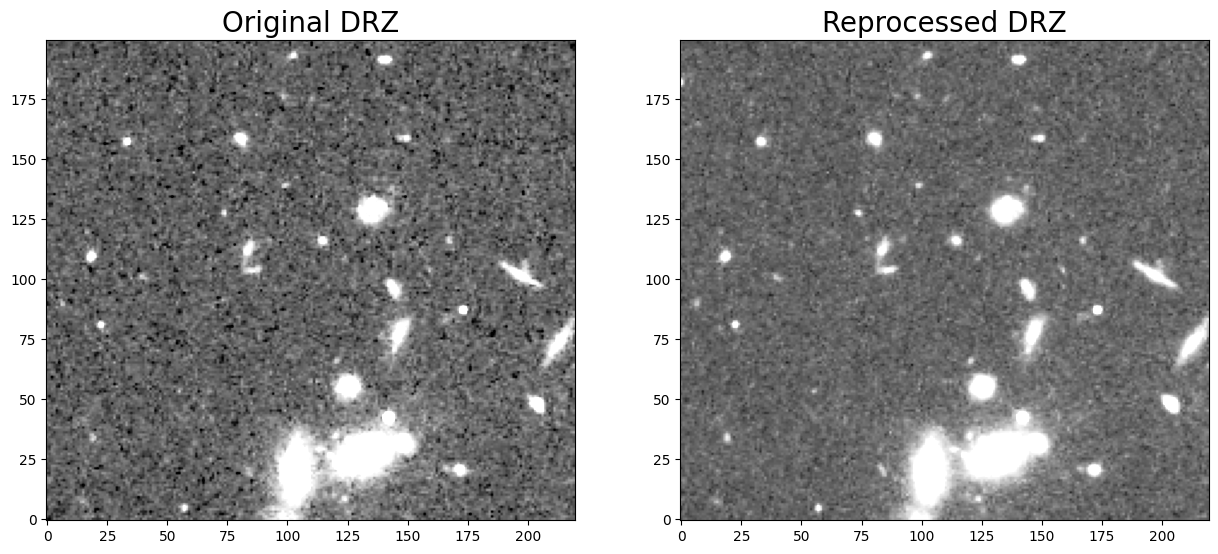

In [24]:
drz_origdata = fits.getdata('orig/ibohbf040_drz.fits', ext=1)
drz_newdata = fits.getdata('ibohbf040_drz.fits', ext=1)

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(drz_origdata[520:720, 750:970], vmin=0.4, vmax=0.6, cmap='Greys_r', origin='lower')
ax2.imshow(drz_newdata[520:720, 750:970], vmin=0.4, vmax=0.6, cmap='Greys_r', origin='lower')

ax1.set_title('Original DRZ', fontsize=20)
ax2.set_title('Reprocessed DRZ', fontsize=20)

Text(0.5, 1.0, 'Reprocessed DRZ')

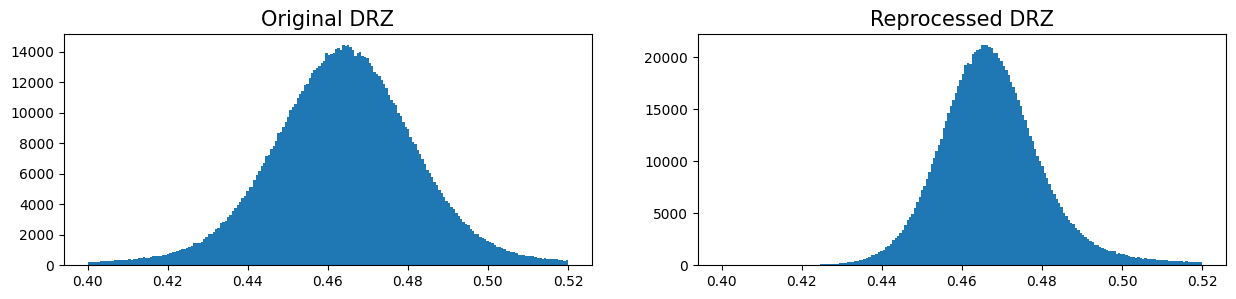

In [25]:
fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

n, bins, patches = ax1.hist(drz_origdata.flatten(), bins=200, range=(0.4, 0.52))
n, bins, patches = ax2.hist(drz_newdata.flatten(), bins=200, range=(0.4, 0.52))

ax1.set_title('Original DRZ', fontsize=15)
ax2.set_title('Reprocessed DRZ', fontsize=15)

<a id="conclusion"></a>
## 6. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Analyzing exposure statistics for each read in an IMA file using `pstat`.
- Reprocessing a single exposure and an image association using `calwf3`.
- Combining the reprocessed exposures using `astrodrizzle`.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see section 3.5.2 for reference to this notebook
    - see section 7.10 for further discussion of time-variable background

    
<a id="about"></a>
## About this Notebook

**Authors:** Jennifer Mack, Harish Khandrika; WFC3 Instrument Team

**Created on:** 2021-09-13

**Updated on:** 2023-11-16

**Source:** The notebook is sourced from [hst_notebooks/notebooks/WFC3/calwf3_recalibration](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/calwf3_recalibration).

<a id="cite"></a>
## Citations

If you use `matplotlib`, `astropy`, `astroquery`, `drizzlepac`, or `wfc3tools` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/license.html)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)
* [Citing `wfc3tools`](https://wfc3tools.readthedocs.io/en/latest/)

***
[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 